In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import epylab as pylab
import torch

from fit_vid_dataset import get_args, Fitter
from homan import getdataset
from homan.prepare.frameinfos import (
    get_frame_infos, get_gt_infos,
    get_frame_info)
from homan.utils.bbox import bbox_xy_to_wh
from homan.pose_optimization import find_optimal_pose, find_optimal_pose
from homan.pose_optimization import PoseOptimizer
from homan.lib2d import maskutils

from PIL import Image
import sys

/home/skynet/miniconda3/envs/phosa16_env/lib/python3.7/site-packages/libyana/meshutils/meshio.py:9: UserWarning: Could not laod tinyobjloader for faster_load_obj, use fast_load_obj
  "Could not laod tinyobjloader for faster_load_obj, use fast_load_obj"
/home/skynet/miniconda3/envs/phosa16_env/lib/python3.7/site-packages/manopth/manolayer.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


In [3]:
cmd = 'fit_vid_dataset.py --dataset epic --split test --optimize_object_scale 0 --result_root results/epic/step1 --num_initializations 400'
sys.argv = cmd.split(' ')

args = get_args()

2022-03-15 14:55:37,291 INFO     Calling with args: Namespace(box_mode='gt', chunk_step=4, data_offset=0, data_step=100, dataset='epic', dataset_mode='chunk', debug=False, epic_hdf5_root=None, epic_root='/home/skynet/Zhifan/datasets/epic', epic_valid_path='/home/skynet/Zhifan/data/allVideos.xlsx', frame_nb=10, gt_masks=0, hand_checkpoint='extra_data/hand_module/pretrained_weights/pose_shape_best.pth', hand_proj_mode='persp', lw_collision=0, lw_contact=0, lw_depth=0, lw_inter=1, lw_pca=0.004, lw_scale_hand=0.001, lw_scale_obj=0.001, lw_sil_hand=0, lw_sil_obj=1, lw_smooth=2000, lw_smooth_hand=2000, lw_smooth_obj=2000, lw_v2d_hand=50, mesh_path=None, num_initializations=400, num_joint_iterations=201, num_obj_iterations=50, only_missing=None, optimize_mano=1, optimize_mano_beta=1, optimize_object_scale=0, output_dir='output', result_root='results/epic/step1', resume=None, resume_indep=False, save_indep=False, seed=0, seq_idx=None, smpl_path='extra_data/smpl', split='test', viz_step=20)


======= Options ========
box_mode: gt
chunk_step: 4
data_offset: 0
data_step: 100
dataset: epic
dataset_mode: chunk
debug: False
epic_hdf5_root: None
epic_root: /home/skynet/Zhifan/datasets/epic
epic_valid_path: /home/skynet/Zhifan/data/allVideos.xlsx
frame_nb: 10
gt_masks: 0
hand_checkpoint: extra_data/hand_module/pretrained_weights/pose_shape_best.pth
hand_proj_mode: persp
lw_collision: 0
lw_contact: 0
lw_depth: 0
lw_inter: 1
lw_pca: 0.004
lw_scale_hand: 0.001
lw_scale_obj: 0.001
lw_sil_hand: 0
lw_sil_obj: 1
lw_smooth: 2000
lw_smooth_hand: 2000
lw_smooth_obj: 2000
lw_v2d_hand: 50
mesh_path: None
num_initializations: 400
num_joint_iterations: 201
num_obj_iterations: 50
only_missing: None
optimize_mano: 1
optimize_mano_beta: 1
optimize_object_scale: 0
output_dir: output
result_root: results/epic/step1
resume: None
resume_indep: False
save_indep: False
seed: 0
seq_idx: None
smpl_path: extra_data/smpl
split: test
viz_step: 20


In [4]:
dataset, image_size = getdataset.get_dataset(
    'epic', split='test', frame_nb=1,
    box_mode='gt', chunk_step=4, dataset_mode='chunk',    
    epic_root=args.epic_root,
    epic_valid_path=args.epic_valid_path)

2022-03-15 14:55:37,311 WARNING  unable to load materials from: model_normalized.mtl
2022-03-15 14:55:37,321 WARNING  specified material (material_0_24)  not loaded!
2022-03-15 14:55:37,324 WARNING  unable to load materials from: model_normalized.mtl
2022-03-15 14:55:37,329 WARNING  specified material (material_0_24)  not loaded!
2022-03-15 14:55:37,331 WARNING  unable to load materials from: model_normalized.mtl
2022-03-15 14:55:37,338 WARNING  specified material (material_3_24)  not loaded!
2022-03-15 14:55:37,340 WARNING  specified material (material_2_24)  not loaded!
2022-03-15 14:55:37,341 WARNING  specified material (material_1_24)  not loaded!
2022-03-15 14:55:37,344 WARNING  specified material (material_0_24)  not loaded!
2022-03-15 14:55:37,351 WARNING  unable to load materials from: model_normalized.mtl
2022-03-15 14:55:37,359 WARNING  specified material (material_4_24)  not loaded!
2022-03-15 14:55:37,363 WARNING  specified material (material_2_24)  not loaded!
2022-03-15 1

Chunking 257 videos in chunks of size 1, skipping 1, every 1 frames
Working with 26784 chunks for ['can', 'cup', 'plate', 'bottle']


In [5]:
fitter = Fitter(
    image_size=image_size,
    resume=None,
    frame_nb=1,
    debug=True,
    gt_masks=0,
    num_obj_iterations=50,
    num_initializations=500,
    hand_checkpoint='extra_data/hand_module/pretrained_weights/pose_shape_best.pth',
    smpl_path='extra_data/smpl'
)

2022-03-15 14:55:40,430 INFO     Loading checkpoint from detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl
2022-03-15 14:55:40,431 INFO     URL https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl cached in /home/skynet/Zhifan/.torch/iopath_cache/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl
2022-03-15 14:55:40,565 INFO     Reading a file from 'Detectron2 Model Zoo'


In [6]:
annots = dataset[0]
fitter._set_paths(sample_folder='tmp/stepbystep', result_root='tmp/')

# Preprocess detections

In [7]:
images_np, camintr, obj_bboxes, hand_bboxes, \
    gt_obj_verts, gt_hand_verts = fitter.preprocess_detections(annots)

Pre-processing detections


# Get indep fit

## get_frame_info (mano_params + obj_mask)

In [8]:
hand_bboxes

{'left_hand': None,
 'right_hand': array([[ 26.666718,  26.666656, 586.66675 , 586.66675 ]], dtype=float32)}

### overall

In [9]:
image_idx = 0
image = images_np[0]
image_hand_boxes = {
    k: boxes[0]
    for k, boxes in hand_bboxes.items() if boxes is not None
}

In [10]:
_person_parameters, _obj_mask_infos, _image = get_frame_info(
    image,
    fitter.hand_predictor,
    fitter.mask_extractor,
    sample_folder=fitter.sample_folder,
    hand_bboxes=[image_hand_boxes],
    obj_bboxes=obj_bboxes[:, 0],
    camintr=camintr[image_idx],
    debug = True,
    image_size=image_size)

### get_person_params

In [11]:
mocap_predictions = fitter.hand_predictor.regress(
    image[..., ::-1],
    [image_hand_boxes],
    add_margin=False,
    debug=True,
    K=camintr[0],
    viz_path='tmp/hands.png')

### obj_mask

In [12]:
_obj_mask_infos = fitter.mask_extractor.masks_from_bboxes(
    image,
    bbox_xy_to_wh(obj_bboxes[:, 0]),
    pred_classes=None,
    image_size=image_size)[0]

#### How the add occlusion behave

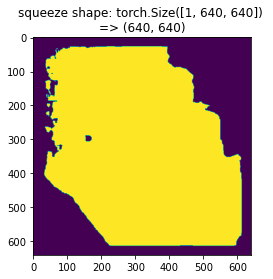

In [13]:
hand_occlusions = _person_parameters['masks'] > 0
pylab.imshow(hand_occlusions)
# pylab.imshow(_obj_mask_infos['crop_mask'])
target_mask = maskutils.add_occlusions(
    [_obj_mask_infos['crop_mask']],
    hand_occlusions,
    [_obj_mask_infos['square_bbox']])[0]

In [ ]:
obj_mask_infos['full_mask

In [17]:
_obj_mask_infos['full_mask'].shape

torch.Size([640, 640])

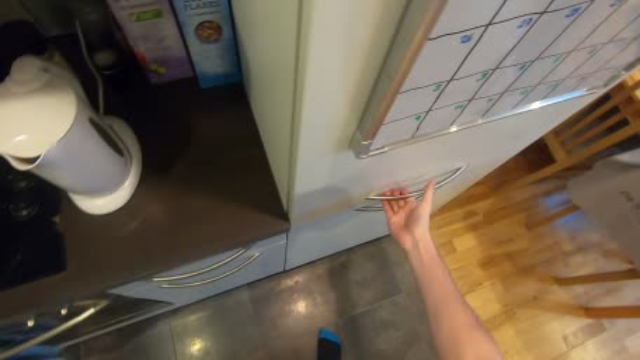

In [14]:
_video_id = 'P11_105'
dataset._read_frame(_video_id, 242)

In [55]:
obj_verts_can = annots['objects'][0]['canverts3d']
obj_faces = annots['objects'][0]['faces']

images = images_np
image_size = images_np[0].shape
vertices = obj_verts_can[0]
faces = obj_faces[0]
annotations = obj_mask_infos
Ks = camintr
viz_path = './tmp/optimal_pose.png'

NameError: name 'obj_mask_infos' is not defined

### find_optimal_pose in one frame

In [20]:
annotation = annotations

vertices = torch.from_numpy(vertices).cuda()
faces = torch.from_numpy(faces).cuda()
mask = annotation['target_crop_mask']
bbox = annotation['bbox']
square_box = annotation['square_bbox']
image_size = image_size
K = Ks[0]

KeyError: 'target_crop_mask'

In [56]:
model = PoseOptimizer(
    ref_image=mask,
    vertices=vertices,
    faces=faces,
    textures=textures,
    rotation_init=rotations_init,
    translation_init=translations_init,
    num_initializations=50,
    K=camintr_roi)

NameError: name 'mask' is not defined

In [33]:
mask

NameError: name 'mask' is not defined

In [30]:
camintr

array([[[ 1.4588031e+03,  0.0000000e+00, -5.4847736e+02],
        [ 0.0000000e+00,  1.4588029e+03,  1.1708572e+03],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]], dtype=float32)

In [ ]:
indep_fit_res, state_dict = fitter.get_indep_fit(
    None, images_np, camintr, obj_bboxes, hand_bboxes, annots
)

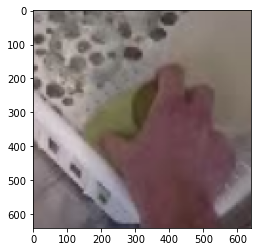

In [40]:
plt.imshow(images_np[0])